# FORCE 2020Well Log Imputation

Firstly we try preparing the data and importing the liabraries important for the problem statement

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler

import missingno as msno

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from sklearn import metrics
from lightgbm import LGBMRegressor

The data for this project has been sourced from the FORCE 2020 Facies prediction competition.

In [2]:
train = pd.read_csv('data/train.csv', sep=';')
test = pd.read_csv('data/test.csv', sep=';')

In [3]:
train.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.528,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.680,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.832,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.984,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
4,15/9-13,495.136,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,...,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0


<AxesSubplot:>

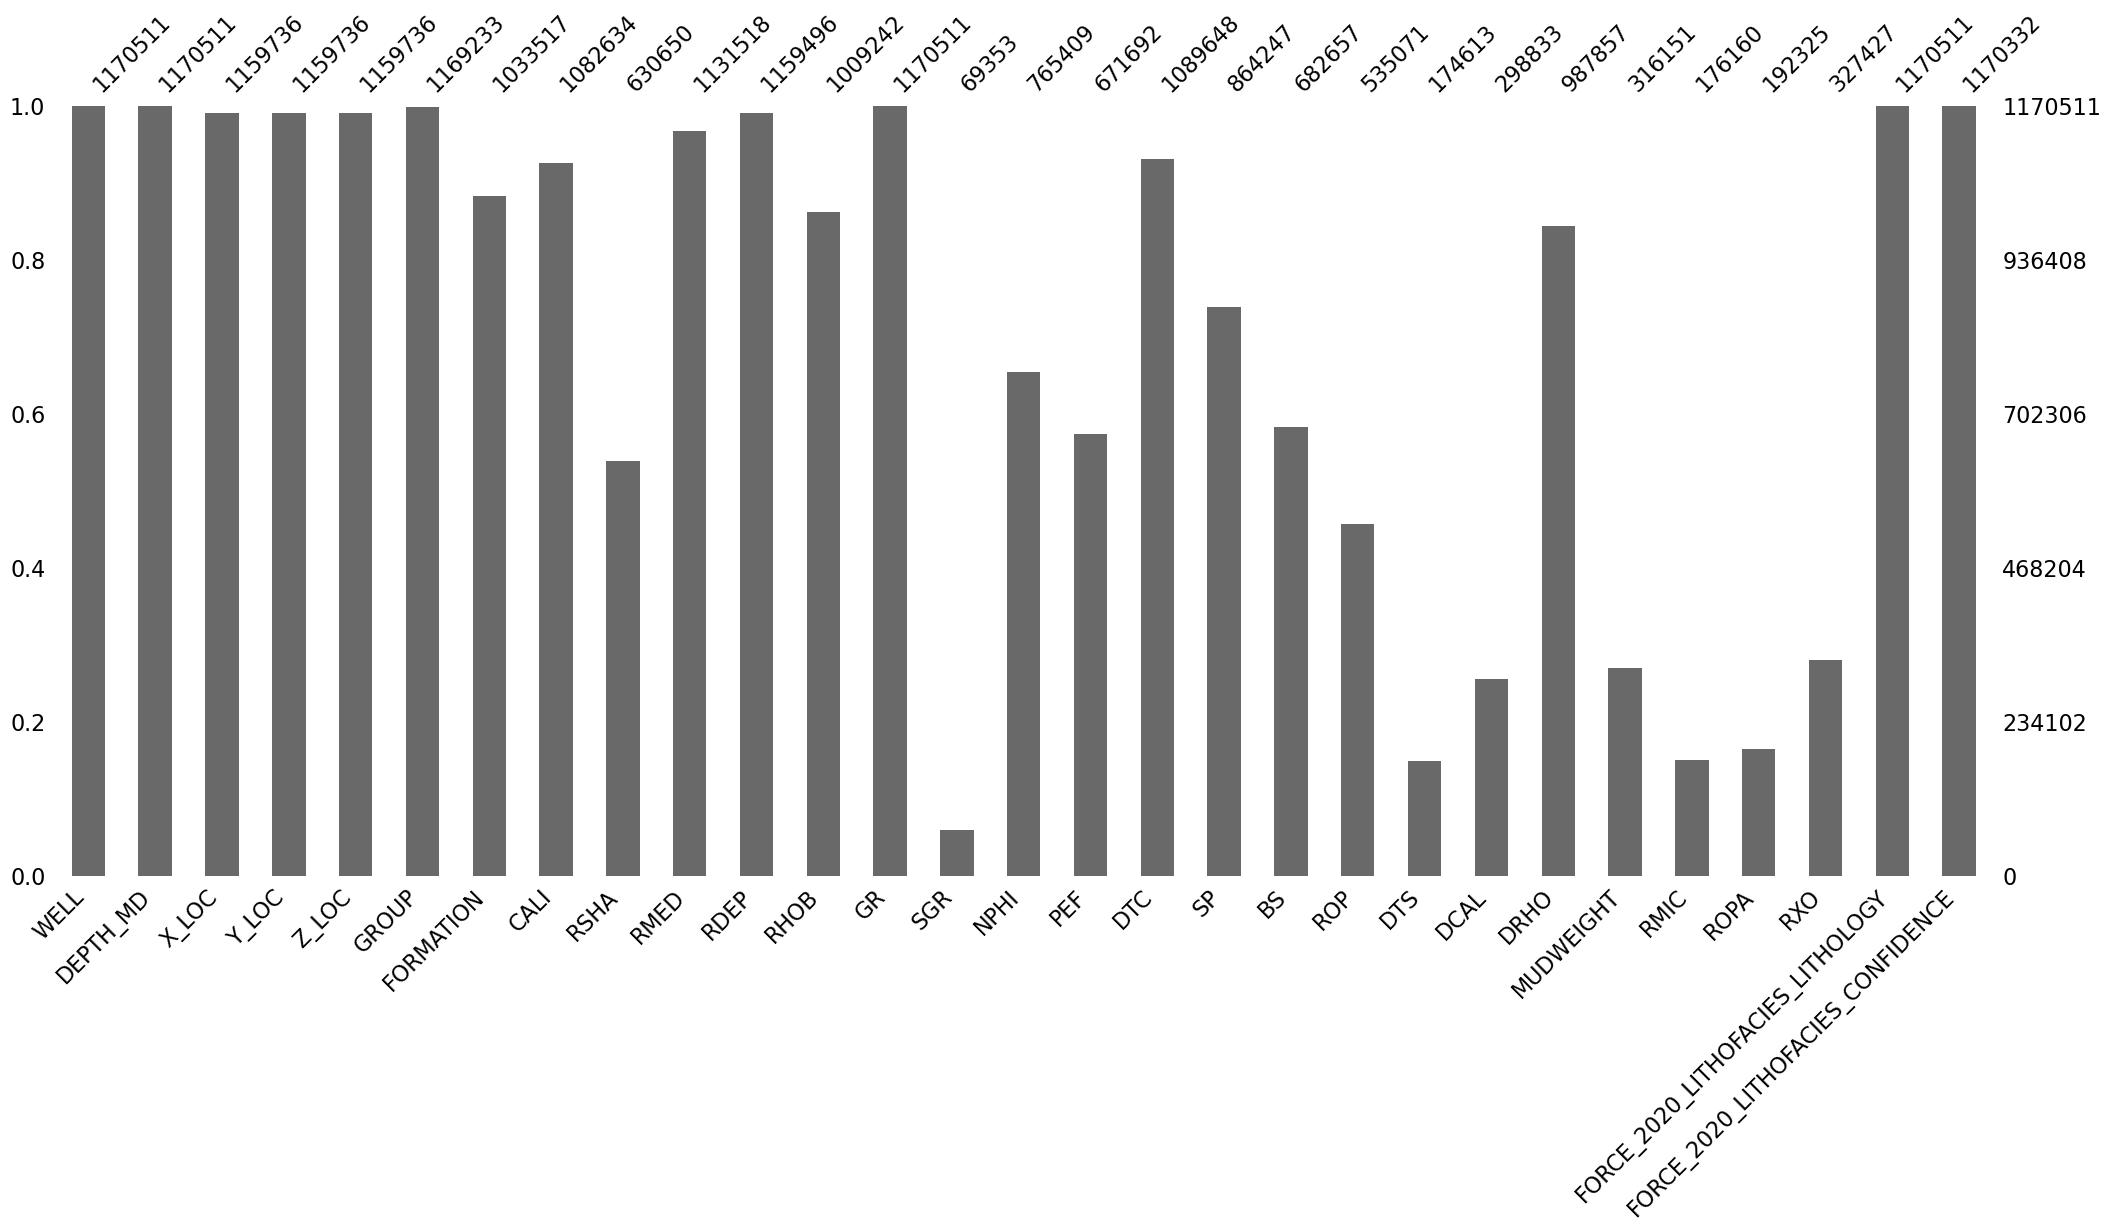

In [4]:
msno.bar(train)

<AxesSubplot:>

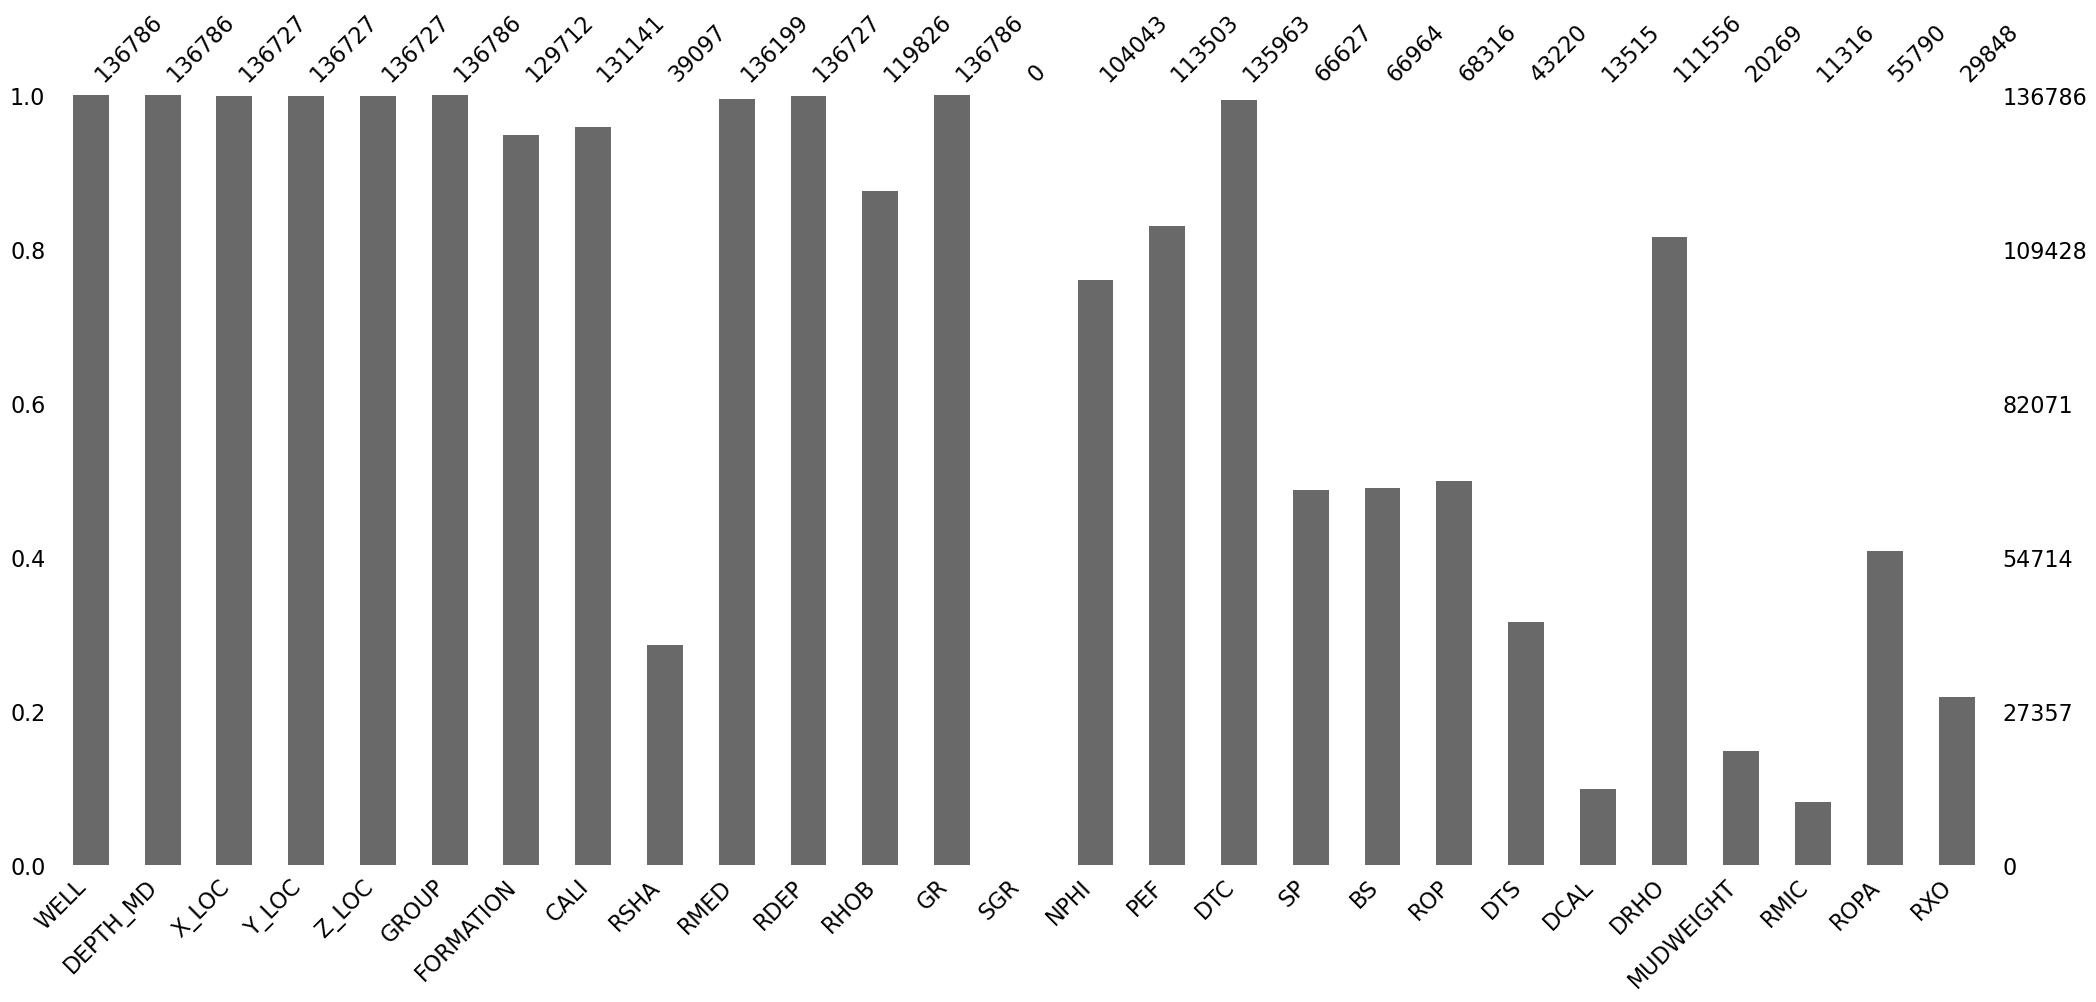

In [5]:
msno.bar(test)

In [6]:
train['FORMATION']

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
             ...    
1170506    Bryne Fm.
1170507    Bryne Fm.
1170508    Bryne Fm.
1170509    Bryne Fm.
1170510    Bryne Fm.
Name: FORMATION, Length: 1170511, dtype: object

C:\Users\lumisong\AppData\Local\Temp\ipykernel_16248\1254897294.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


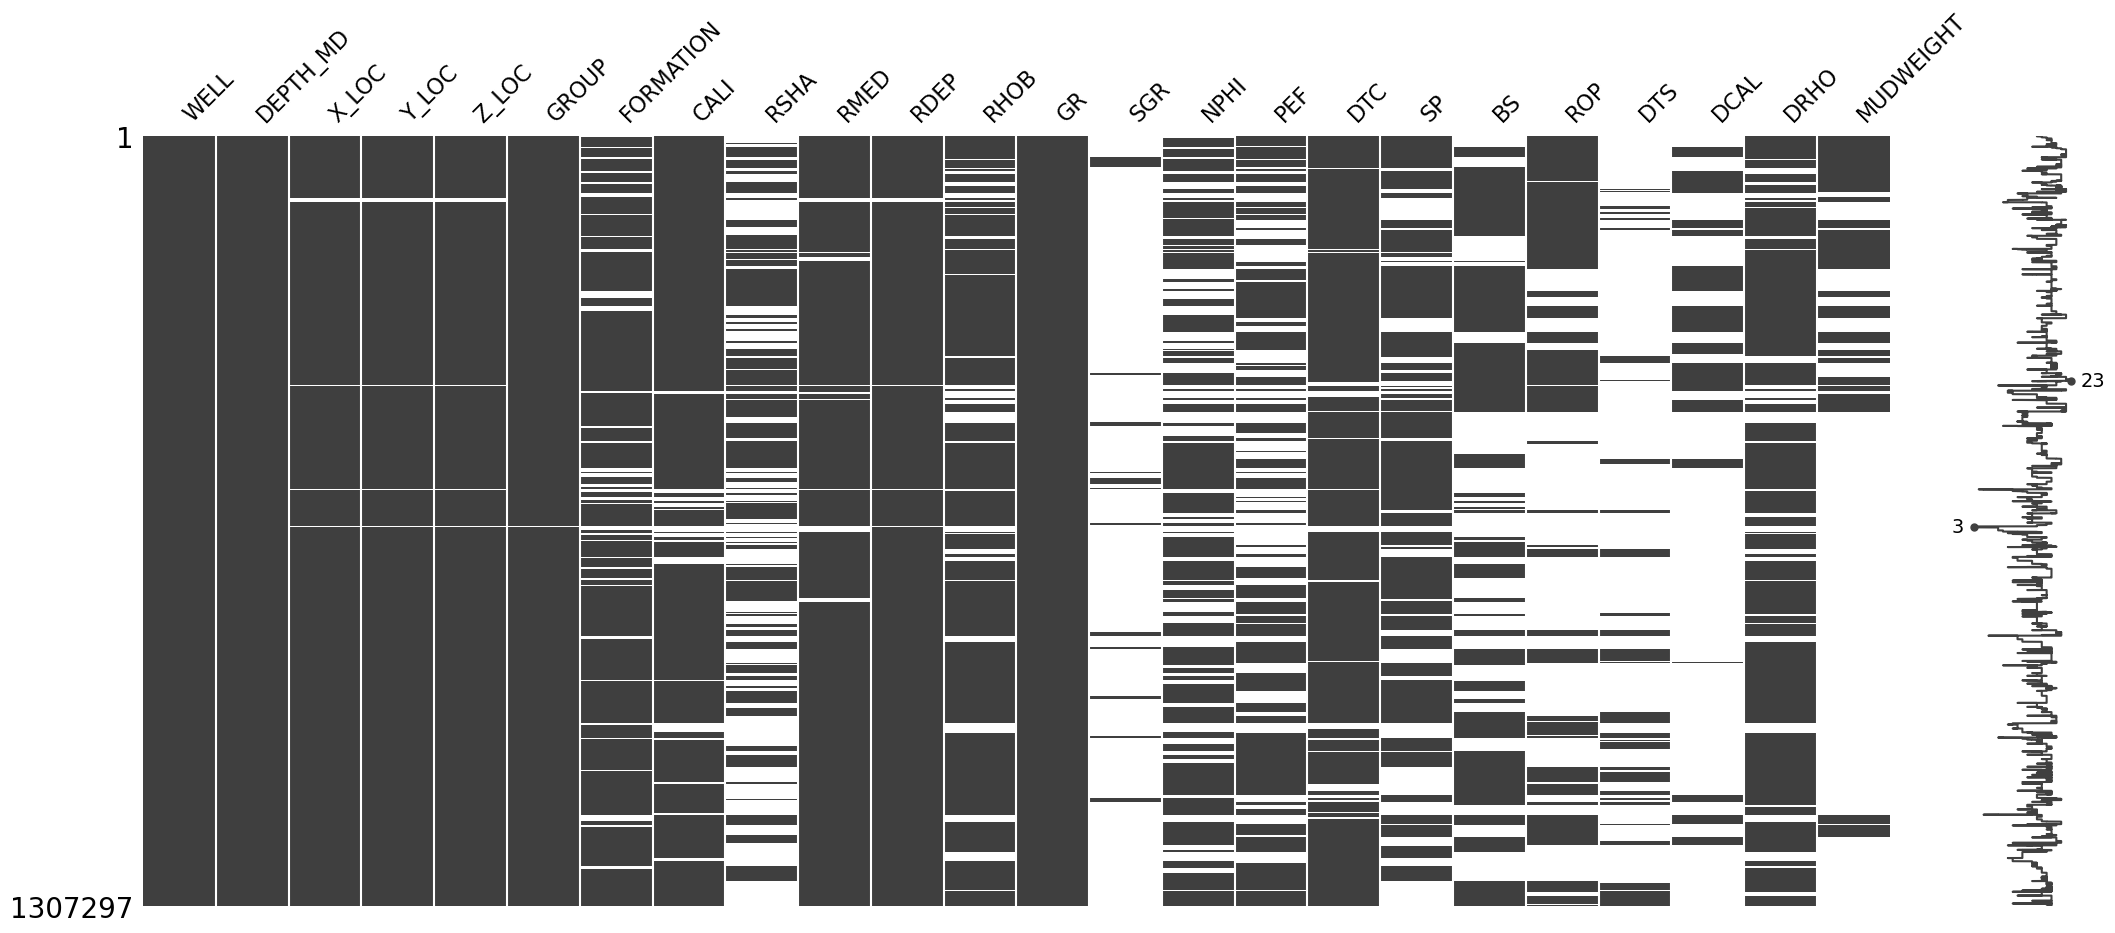

In [9]:
msno.matrix(pd.concat([train, test]).iloc[:, :-5])
plt.tight_layout()
fig = plt.gcf()
rect = fig.patch
rect.set_facecolor('white')
plt.savefig('figures/force_missingno.png', dpi=150)

In [ ]:
well_encoder = LabelEncoder()
group_encoder = LabelEncoder()
form_encoder = LabelEncoder()

well_encoder.fit(pd.concat([train, test]).WELL.replace(np.nan, ''))
group_encoder.fit(pd.concat([train, test]).GROUP.replace(np.nan, ''))
form_encoder.fit(pd.concat([train, test]).FORMATION.replace(np.nan, ''))

train['WELLe'] = well_encoder.transform(train.WELL.replace(np.nan, ''))
train['WELLe'] = train['WELLe'].astype(int)
train['GROUPe'] = group_encoder.transform(train.GROUP.replace(np.nan, ''))
train['GROUPe'] = train['GROUPe'].astype(int)
train['FORMATIONe'] = form_encoder.transform(train.FORMATION.replace(np.nan, ''))
train['FORMATIONe'] = train['FORMATIONe'].astype(int)

test['WELLe'] = well_encoder.transform(test.WELL.replace(np.nan, ''))
test['WELLe'] = test['WELLe'].astype(int)
test['GROUPe'] = group_encoder.transform(test.GROUP.replace(np.nan, ''))
test['GROUPe'] = test['GROUPe'].astype(int)
test['FORMATIONe'] = form_encoder.transform(test.FORMATION.replace(np.nan, ''))
test['FORMATIONe'] = test['FORMATIONe'].astype(int)

In [ ]:
for column in test.columns:
    print(column, np.sum(train[column].isna())/3693222*100)

Lets plot a map and see where the training wells and test wells are located in cartesian space.

In [ ]:
head = train.sort_values('DEPTH_MD').drop_duplicates(['WELL'])
head_test = test.sort_values('DEPTH_MD').drop_duplicates(['WELL'])
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot(111)
ax.grid()
ax.scatter(head.X_LOC, head.Y_LOC, label='train')
ax.scatter(head_test.X_LOC, head_test.Y_LOC, label='test')
ax.set_aspect('equal')
ax.legend()
ax.set_xlabel('East (m)')
ax.set_ylabel('North (m)')
fig.savefig('figures/f2020_location_map.png', dpi=150)

## Sampling Statistics
The number of missing values and missing values per well and per zone.

Wells where key logs DTE, DTSE and RHOBE are missing? Are there any trends here, how might the distribution of missing data affect our imputation performance? **In your accuracy score Debajoy it would be useful to do some deeper analysis to see if any zones perform better than others, an important part of this process is to understand the limitations of the algorithm you are using and to know when and where it will and won't work -> and for a paper, most importantly, why.**

In [ ]:
data = pd.concat([train, test])
missing_pc = pd.DataFrame({'ALL':data.count()/data.shape[0]})
for well, sub in data.groupby('WELL'):
    missing_pc[well] = 1- sub.count()/sub.shape[0]
for zn, sub in data.groupby('FORMATION'):
    missing_pc[zn] = 1- sub.count()/sub.shape[0]

import matplotlib as mpl

sns.set_style('whitegrid')
sns.set_context('paper')
plasma_r5 = mpl.cm.get_cmap('plasma_r', 11)
plasma_r5.colors[0] = (1.0, 1.0, 1.0, 1.0)

fig = plt.figure(figsize=(10, 6))
sns.heatmap(missing_pc.T.iloc[:110, :-5], cbar_kws={'label':'Fraction Missing'}, cmap=plasma_r5, vmin=-0.1, vmax=1)
plt.tight_layout()
fig.savefig('figures/well_fraction_f20_missing.png', dpi=150)

fig = plt.figure(figsize=(10, 6))
sns.heatmap(missing_pc.T.iloc[110:, :-5], cbar_kws={'label':'Fraction Missing'}, cmap=plasma_r5, vmin=-0.1, vmax=1)
plt.tight_layout()
fig.savefig('figures/zone_fraction_f20_missing.png', dpi=150)

## Feature Engineering



In [ ]:
# logs chosen as input for this set of model
training_logs = ['X_LOC', 'Y_LOC', 'Z_LOC',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF',
       'DTC', 'SP', 'ROP', 'DTS', 'DRHO', 'WELLe', 'GROUPe', 'FORMATIONe']

# dropping rows that are all NA (i.e. 10 of the logs are all nan)
train_fe = train[training_logs].dropna(thresh=13).copy()
print(train_fe.shape)

train_fe['RD10'] = np.log10(train_fe['RDEP']+1)
train_fe['RM10'] = np.log10(train_fe['RMED']+1)
train_fe['RS10'] = np.log10(train_fe['RSHA']+1)

# repeat for test data
test_fe = test[training_logs].dropna(thresh=13).copy()
print(test_fe.shape)

test_fe['RD10'] = np.log10(test_fe['RDEP']+1)
test_fe['RM10'] = np.log10(test_fe['RMED']+1)
test_fe['RS10'] = np.log10(test_fe['RSHA']+1)

feature_logs = ['X_LOC', 'Y_LOC', 'Z_LOC',
       'CALI', 'RS10', 'RM10', 'RD10', 'RHOB', 'GR', 'NPHI', 'PEF',
       'DTC', 'SP', 'ROP', 'DTS', 'DRHO', 'WELLe', 'GROUPe', 'FORMATIONe']

# scaling
sscaler = StandardScaler()
sscaler.fit(train_fe)

train_fe.loc[:, :] = sscaler.transform(train_fe)
test_fe.loc[:, :] = sscaler.transform(test_fe)

# lets add a feature for plotting that tells us how many sample of a super-group is available for training
pc_missing_zone_dtc = dict()
pc_missing_zone_dts = dict()
pc_missing_zone_rhob = dict()

for fm, val in train_fe.groupby("GROUPe"):
    if val.shape[0] == 0:
        a = 1
        b = 1
        c = 1
    else:
        a = val.shape[0] - np.sum(val.DTC.isna())
        b = val.shape[0] - np.sum(val.DTS.isna())
        c = val.shape[0] - np.sum(val.RHOB.isna())
    pc_missing_zone_dtc[f"{fm:.08f}"] = a
    pc_missing_zone_dts[f"{fm:.08f}"] = b
    pc_missing_zone_rhob[f"{fm:.08f}"] = c
    
test_fe["Grp_TSS_DTC"] = test_fe.GROUPe.apply(lambda x: f"{x:.08f}").map(pc_missing_zone_dtc)
test_fe["Grp_TSS_DTS"] = test_fe.GROUPe.apply(lambda x: f"{x:.08f}").map(pc_missing_zone_dts)
test_fe["Grp_TSS_RHOB"] = test_fe.GROUPe.apply(lambda x: f"{x:.08f}").map(pc_missing_zone_rhob)
train_fe["Grp_TSS_DTC"] = train_fe.GROUPe.apply(lambda x: f"{x:.08f}").map(pc_missing_zone_dtc)
train_fe["Grp_TSS_DTS"] = train_fe.GROUPe.apply(lambda x: f"{x:.08f}").map(pc_missing_zone_dts)
train_fe["Grp_TSS_RHOB"] = train_fe.GROUPe.apply(lambda x: f"{x:.08f}").map(pc_missing_zone_rhob)

# lets add a feature for plotting that tells us how many samples of a formation is available for training
pc_missing_zone_dtc = dict()
pc_missing_zone_dts = dict()
pc_missing_zone_rhob = dict()

for fm, val in train_fe.groupby("FORMATIONe"):
    if val.shape[0] == 0:
        a = 1
        b = 1
        c = 1
    else:
        a = val.shape[0] - np.sum(val.DTC.isna())
        b = val.shape[0] - np.sum(val.DTS.isna())
        c = val.shape[0] - np.sum(val.RHOB.isna())
    pc_missing_zone_dtc[f"{fm:.08f}"] = a
    pc_missing_zone_dts[f"{fm:.08f}"] = b
    pc_missing_zone_rhob[f"{fm:.08f}"] = c
    
# TSS -> Training Sample Size
test_fe["Fm_TSS_DTC"] = test_fe.FORMATIONe.apply(lambda x: f"{x:.08f}").map(pc_missing_zone_dtc)
test_fe["Fm_TSS_DTS"] = test_fe.FORMATIONe.apply(lambda x: f"{x:.08f}").map(pc_missing_zone_dts)
test_fe["Fm_TSS_RHOB"] = test_fe.FORMATIONe.apply(lambda x: f"{x:.08f}").map(pc_missing_zone_rhob)
train_fe["Fm_TSS_DTC"] = train_fe.FORMATIONe.apply(lambda x: f"{x:.08f}").map(pc_missing_zone_dtc)
train_fe["Fm_TSS_DTS"] = train_fe.FORMATIONe.apply(lambda x: f"{x:.08f}").map(pc_missing_zone_dts)
train_fe["Fm_TSS_RHOB"] = train_fe.FORMATIONe.apply(lambda x: f"{x:.08f}").map(pc_missing_zone_rhob)

## Training Models

In [ ]:
def data_prep(data, j, set_to_nan=0.3):
    """This method sets set_to_nan fraction of the values to nan so we can measure the model accuracy.
    """
    data = data.copy()
    sub = data.dropna(subset=[j])
    rand_set_mask = np.random.random(len(sub)) < set_to_nan
    replace = sub.index[rand_set_mask]
    data.loc[replace, j] = np.nan
    data['set_nan'] = False
    data.loc[replace, 'set_nan'] = True
    data['was_nan'] = data[j].isna()
    print('Col, InputSize, Number of Nan, % NaN, Original Nan', 'Training Size')
    print(
        f'{j:>3}',
        f'{data.shape[0]:>10}',
        f'{replace.size:>14}',
        f'{100*np.sum(data.set_nan)/sub.shape[0]:>6.2f}',
        f'{np.sum(data.was_nan):>13}',
        f'{sub.shape[0]-replace.size:>13}'
    )

    return data, replace

In [ ]:
missing = pd.DataFrame({
    "all_data":pd.concat([train, test])[training_logs].isna().sum(axis=0)/pd.concat([train, test])[training_logs].shape[0]*100,
    "train":train_fe[feature_logs].isna().sum(axis=0)/train_fe.shape[0]*100,
    "test":test_fe[feature_logs].isna().sum(axis=0)/test_fe.shape[0]*100
})
missing

In [ ]:
imputation_train_dfs = dict()
imputation_train_keys = ['DTC', 'DTS', 'RHOB']

for key in imputation_train_keys:
    imputation_train_dfs[key] = data_prep(train_fe.copy(), key)

**because random is used to create the training gaps -> we might need to rethink this so the numbre of nan for training in each case stays relatively constant** Also, this approach troubles me a little because when logs are missing the missing sections in logs are usually associated with each other, *i.e.* missing dtse -> missing dte as well

## Imputaiton Models

Various imputation models are tried:

 - LGBM with MICE (Random imputation order).
 - LGBM with MICE (Ascending number of missing imputation order).

In [ ]:
# training models

imputation_args = dict(
    # Random Order MICE - LGBM
    lgbasc = dict(
        training_set = feature_logs,
        estimator = LGBMRegressor(random_state=456, n_jobs=4),
        kwargs = dict(random_state=456, max_iter=10, tol=0.01, imputation_order='ascending',)
    ),
    # Ascending Order MICE - LGBM
    lgbasc = dict(
        training_set = feature_logs,
        estimator = LGBMRegressor(random_state=456, n_jobs=4),
        kwargs = dict(random_state=456, max_iter=10, tol=0.01, imputation_order='ascending',)
    ),
    # Bayesian Ridge Regression
    brr = dict(
        estimator = BayesianRidge(),
        training_set = feature_logs,
        kwargs=dict(random_state=456), 
    ),
    brr1 = dict(
        estimator = BayesianRidge(),
        training_set = feature_logs,
        kwargs=dict(random_state=456, max_iter=1, imputation_order="ascending"), 
    ),
# knn had to be disabled, I don't think the scikit learn one scales well to large data sets.
#     knn = dict(
#         training_set = feature_logs,
#         estimator = KNeighborsRegressor(n_jobs=4),
#         kwargs = dict(random_state=456, max_iter=10, tol=0.01)
#     ),
#     knn1 = dict(
#         training_set = feature_logs,
#         estimator = KNeighborsRegressor(n_jobs=4),
#         kwargs = dict(random_state=456, max_iter=1, imputation_order="ascending", tol=0.01)
#     ),
)

def train_models(data, training_set=None, estimator=None, **kwargs):
    """Train a model using a MICE iterative imputer.
    """
    # print(kwargs)
    mice = IterativeImputer(estimator, **kwargs['kwargs'])
    mice.fit(data[training_set])
    data.loc[:, training_set] = mice.transform(data[training_set])
    return data, mice

In [ ]:
import time

In [ ]:
models = dict()
imputed = dict()
for imp_mod, args in imputation_args.items():
# for imp_mod, args in [(key, imputation_args[key]) for key in ["brr1", "knn1"]]:
    for key, val in imputation_train_dfs.items():
        start = time.time()
        imputed[imp_mod+'_'+key], models[imp_mod+'_'+key] = train_models(val[0].copy(), **args)
        print(f"{imp_mod} for {key} training complted in {time.time()-start} seconds.")

In [ ]:
from collections import defaultdict

def evaluate(data1, data2, j):
    """Evaluate the models against the NANed data from the training set.
    """
    mask = data1.set_nan.values
    truth = data2.loc[mask, j].values
    test = data1.loc[mask, j].values
    se = np.power((truth - test)/truth, 2)
    score = np.nanmean(np.power(se, 0.5))*100.0
    er = dict(
        perc_error=score,
        explained_var=metrics.explained_variance_score(truth, test),
        max_error=metrics.max_error(truth, test),
        mae=metrics.mean_absolute_error(truth, test),
        mse=metrics.mean_squared_error(truth, test),
        r2=metrics.r2_score(truth, test),
    )
    return er

scores = defaultdict(dict)
for key, d in imputed.items():
    mod, key = key.split('_')
    scores[f'{key}_{mod}'] = evaluate(d, train_fe, key)

mices_score = pd.DataFrame(scores)
mices_score.T

In [ ]:
fig, axs = plt.subplots(nrows=4, figsize=(20, 10), sharex=True)
mod = "brr"

axs[0].plot(train_fe.DTC[imputed[f'{mod}_DTC'].set_nan].values)
axs[0].plot(imputed[f"{mod}_DTC"].DTC[imputed[f'{mod}_DTC'].set_nan].values)
axs[1].plot(train_fe.DTS[imputed[f'{mod}_DTS'].set_nan].values)
axs[1].plot(imputed[f"{mod}_DTS"].DTS[imputed[f'{mod}_DTS'].set_nan].values)
axs[2].plot(train_fe.RHOB[imputed[f'{mod}_RHOB'].set_nan].values)
axs[2].plot(imputed[f"{mod}_RHOB"].RHOB[imputed[f'{mod}_RHOB'].set_nan].values)
axs[3].plot(train_fe.isna().sum(axis=1)[imputed[f'{mod}_DTC'].set_nan].values)
axs[3].plot(train_fe.isna().sum(axis=1)[imputed[f'{mod}_DTS'].set_nan].values)
axs[3].plot(train_fe.isna().sum(axis=1)[imputed[f'{mod}_RHOB'].set_nan].values)

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=9, figsize=(15, 20), sharey="row", sharex="col")
mod='lgbasc'
logs = [ 'ZONE', 'GR', 'NPHI', 'PEF', 'RM10', 'RD10', 'DT', 'DTS', "RHOB"]
for row, (well, val) in zip(range(4), train.groupby("WELL")):
    axs[row, -3].plot(imputed[f"{mod}_DT"].loc[val.index, "DT"], -val.TVDSS, 'g')
    axs[row, -2].plot(imputed[f"{mod}_DTS"].loc[val.index, "DTS"], -val.TVDSS, 'g')
    axs[row, -1].plot(imputed[f"{mod}_RHOB"].loc[val.index, "RHOB"], -val.TVDSS, 'g')
    for col, log in enumerate(logs):
        axs[row, col].plot(val[log], -val.TVDSS, 'k', alpha=0.5)
for col, log in enumerate(logs):
    axs[0, col].set_title(log)
plt.tight_layout()

# One Step LGBM

Here we test the MICE imputation against a single imputation pass using LGBM. The inputs and the predictors are the same but multiple imputation chaining is not applied.

In [ ]:
dt_lgbm = LGBMRegressor(random_state=456, max_depth=5, num_leaves=100)
dts_lgbm = LGBMRegressor(random_state=456, max_depth=5, num_leaves=100)
rho_lgbm = LGBMRegressor(random_state=456, max_depth=5, num_leaves=100)

In [ ]:
dt_col = feature_logs.copy()
dt_col.remove("DTC")
dts_col = feature_logs.copy()
dts_col.remove("DTS")
rhob_col = feature_logs.copy()
rhob_col.remove("RHOB")

dt_lgbm.fit(imputation_train_dfs['DTC'][0].dropna(subset=['DTC']).loc[:, dt_col], imputation_train_dfs['DTC'][0].dropna(subset=['DTC'])['DTC'])
dts_lgbm.fit(imputation_train_dfs['DTS'][0].dropna(subset=['DTS']).loc[:, dts_col], imputation_train_dfs['DTS'][0].dropna(subset=['DTS'])['DTS'])
rho_lgbm.fit(imputation_train_dfs['RHOB'][0].dropna(subset=['RHOB']).loc[:, rhob_col], imputation_train_dfs['RHOB'][0].dropna(subset=['RHOB'])['RHOB'])

dt_one_imputed = imputation_train_dfs['DTC'][0].copy()
dts_one_imputed = imputation_train_dfs['DTS'][0].copy()
rhob_one_imputed = imputation_train_dfs['RHOB'][0].copy()



In [ ]:
dt_one_imputed.loc[dt_one_imputed["DTC"].isna(), "DTC"] = dt_lgbm.predict(imputation_train_dfs['DTC'][0][dt_col])[dt_one_imputed["DTC"].isna().values]
dts_one_imputed.loc[dts_one_imputed["DTS"].isna(), "DTS"] = dts_lgbm.predict(imputation_train_dfs['DTS'][0][dts_col])[dts_one_imputed["DTS"].isna().values]
rhob_one_imputed.loc[rhob_one_imputed["RHOB"].isna(), "RHOB"] = rho_lgbm.predict(imputation_train_dfs['RHOB'][0][rhob_col])[rhob_one_imputed["RHOB"].isna().values]

In [ ]:
mices_score["DTC_onepass"] = evaluate(dt_one_imputed, train_fe, "DTC").values()
mices_score["DTS_onepass"] = evaluate(dts_one_imputed, train_fe, "DTS").values()
mices_score["RHOB_onepass"] = evaluate(rhob_one_imputed, train_fe, "RHOB").values()

mices_score.sort_index(axis=1).T.round(2)

### Observations from the training results:

  - KNN could not be run due to size of data set

In [ ]:
imputed["lgbonce_DTC"] = dt_one_imputed
imputed["lgbonce_DTS"] = dts_one_imputed
imputed["lgbonce_RHOB"] = rhob_one_imputed

In [ ]:
# find metrics for predicting Y when X is missing
missing_logs = ['DTC', 'DTS', 'GR', 'NPHI', 'PEF', 'RHOB', 'RM10', 'RD10']

missing_scores = []
for missing_log in missing_logs:
    scores_when_missing = defaultdict(dict)
    for key, d in imputed.items():
        mod, key = key.split('_')
        if missing_log == key:
            scores_when_missing[f'{key}_{mod}'] = evaluate(d, train_fe, key)
            scores_when_missing[f'{key}_{mod}']
        else:

            mask = train[missing_log].isna()
            d = d.loc[~mask, :]
            scores_when_missing[f'{key}_{mod}'] = evaluate(d, train_fe.loc[~mask, :], key)
            scores_when_missing[f'{key}_{mod}']
    temp_df = pd.DataFrame(scores_when_missing)
    temp_df["always_present_log"] = missing_log
    missing_scores.append(temp_df)
missing_scores = pd.concat(missing_scores)

In [ ]:
fig = plt.figure(figsize=(20, 10))
melted = missing_scores.reset_index().melt(id_vars=["index", "always_present_log"], var_name="model").sort_values("model")
isnonemodel = melted.model.apply(lambda x: x.split("_")[0]) == melted.always_present_log
melted.loc[isnonemodel, "always_present_log"] = "none"
g = sns.FacetGrid(melted, height=5, aspect=2, col="index", col_wrap=2, sharey=False)
g.map_dataframe(sns.barplot, x="model", y="value", hue="always_present_log", palette="pastel",  hue_order=["none", 'DT', 'DTS', 'GR', 'NPHI', 'PEF', 'RHOB', 'RM10', 'RD10'])
g.add_legend(title="Log has no\nNan Values")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

## Test Evaluation

Here we use the trained models on the blind well test sets to see if the predictive accuracy is the same.

In [ ]:
imputation_test_dfs = dict()
imputation_test_keys = ['DTC', 'DTS', 'RHOB']

for key in imputation_test_keys:
    imputation_test_dfs[key] = data_prep(test_fe.copy(), key, 1.0)

In [ ]:
# impute test sets
imputed_test = dict()
for imp_mod, args in imputation_args.items():
    for key, val in imputation_test_dfs.items():
        temp_df = val[0].copy()
        temp_df.loc[:, args["training_set"]] = models[imp_mod+'_'+key].transform(val[0][args["training_set"]])
        imputed_test[imp_mod+'_'+key] = temp_df

In [ ]:
dt_lgbm.predict(imputation_test_dfs['DTC'][0][dt_col]).shape

In [ ]:
dt_one_imputed_test["DTC"].shape

In [ ]:
# impute tests sets using lgbonce models
dt_one_imputed_test = imputation_test_dfs['DTC'][0].copy()
dts_one_imputed_test = imputation_test_dfs['DTS'][0].copy()
rhob_one_imputed_test = imputation_test_dfs['RHOB'][0].copy()
# dt_one_imputed_test.loc[dt_one_imputed_test["DTC"].isna(), "DTC"] = dt_lgbm.predict(imputation_test_dfs['DTC'][0][dt_col])[dt_one_imputed_test["DTC"].isna().values]
# dts_one_imputed_test.loc[dts_one_imputed_test["DTS"].isna(), "DTS"] = dts_lgbm.predict(imputation_test_dfs['DTS'][0][dts_col])[dts_one_imputed_test["DTS"].isna().values]
# rhob_one_imputed_test.loc[rhob_one_imputed_test["RHOB"].isna(), "RHOB"] = rho_lgbm.predict(imputation_test_dfs['RHOB'][0][rhob_col])[rhob_one_imputed_test["RHOB"].isna().values]
dt_one_imputed_test["DTC"] = dt_lgbm.predict(imputation_test_dfs['DTC'][0][dt_col])
dts_one_imputed_test["DTS"] = dts_lgbm.predict(imputation_test_dfs['DTS'][0][dts_col])
rhob_one_imputed_test["RHOB"] = rho_lgbm.predict(imputation_test_dfs['RHOB'][0][rhob_col])

imputed_test["lgbonce_DTC"] = dt_one_imputed_test
imputed_test["lgbonce_DTS"] = dts_one_imputed_test
imputed_test["lgbonce_RHOB"] = rhob_one_imputed_test

In [ ]:
scores_test = dict()
for key, d in imputed_test.items():
    mod, key = key.split('_')
    scores_test[f'{key}_{mod}'] = evaluate(d, test_fe, key)
pd.DataFrame(scores_test).sort_index(axis=1).T.round(2)

In [ ]:
from matplotlib import cm

for mod, name in zip(['lgbrand', 'brr', 'brr1', 'lgbonce'], ['GBT Random', 'Bayesian Ridge Regression', 'Bayesian Ridge Regression Once', "GBT Direct"]):
    fig, axs = plt.subplots(nrows=4, ncols=2, gridspec_kw={"width_ratios":[9, 1]}, figsize=(15, 7), sharex="col")
    
    gs = axs[2, 1].get_gridspec()
    # remove the underlying axes
    for ax in axs[:, 1]:
        ax.remove()
    cbar_ax = fig.add_subplot(gs[1:, -1])
    
    
#     cb = axs[:, 1]
    axs = axs[:, 0]
    axs[0].plot(imputed_test[f"{mod}_DTC"].DTC.values)
    axs[0].plot(test_fe.DTC.values)
    axs0_2 = axs[0].twinx()
    axs0_2.grid(False)
    axs0_2.plot(test_fe.Grp_TSS_DTC.values, 'k')
    ylabels = ['{:,.0f}'.format(x) + 'K' for x in axs0_2.get_yticks()/1000]
    axs0_2.set_yticklabels(ylabels)
    axs[0].set_ylabel("DTC")
    axs[1].plot(imputed_test[f"{mod}_DTS"].DTS.values)
    axs[1].plot(test_fe.DTS.values)
    axs[1].set_ylabel("DTS")
    axs1_2 = axs[1].twinx()
    axs1_2.grid(False)
    axs1_2.plot(test_fe.Grp_TSS_DTS.values, 'k')
    ylabels = ['{:,.0f}'.format(x) + 'K' for x in axs1_2.get_yticks()/1000]
    axs1_2.set_yticklabels(ylabels)
    axs[2].plot(imputed_test[f"{mod}_RHOB"].RHOB.values)
    axs[2].plot(test_fe.RHOB.values)
    axs[2].set_ylabel("RHOB")
    axs2_2 = axs[2].twinx()
    axs2_2.grid(False)
    axs2_2.plot(test_fe.Grp_TSS_RHOB.values, 'k')
    ylabels = ['{:,.0f}'.format(x) + 'K' for x in axs2_2.get_yticks()/1000]
    axs2_2.set_yticklabels(ylabels)

    test_n = test_fe/test_fe
    test_n = test_n[feature_logs]
    test_n = test_n[sorted(test_n.columns)]
    for i, col in enumerate(test_n.columns):
        test_n[col] = (i)
        test_n.loc[~test_fe[col].isna().values, col] = np.nan
        
    missing = axs[3].imshow(test_n.T.values, aspect='auto', cmap=cm.get_cmap('tab20', test_n.shape[1]), interpolation='none', origin='lower', vmin=0, vmax=test_n.shape[1])
    axs[3].set_ylabel("Missing Features")
    axs[3].set_xlabel("Sample")
    axs[0].set_title(f"Imputation Validation Samples for {name}", fontsize=12)
    axs[3].set_yticklabels([])
    axs[3].grid(False)
    plt.colorbar(missing, cax=cbar_ax,)
    cbar_ax.set_yticks([], minor=False, major=False)
    cbar_ax.set_yticklabels([])
    
    
    for lab, v in zip(sorted(test_n.columns.to_list()), np.linspace(0.2, 18.2, test_n.shape[1])):
        cbar_ax.text(-0.5, v, lab, fontsize=9, ha='right')
    cbar_ax.set_title("Missing Features")
    fig.savefig(f'figures/qual_test_f20_{mod}.png', dpi=150)

In [ ]:

zoom = slice(29530,31000)

for mod, name in zip(['lgbrand', 'brr', 'brr1', 'lgbonce'], ['GBT Random', 'Bayesian Ridge Regression', 'Bayesian Ridge Regression Once', "GBT Direct"]):
    fig, axs = plt.subplots(nrows=4, ncols=2, gridspec_kw={"width_ratios":[9, 1]}, figsize=(15, 7), sharex="col")
    
    gs = axs[2, 1].get_gridspec()
    # remove the underlying axes
    for ax in axs[:, 1]:
        ax.remove()
    cbar_ax = fig.add_subplot(gs[1:, -1])
    
    
#     cb = axs[:, 1]
    axs = axs[:, 0]
    axs[0].plot(imputed_test[f"{mod}_DTC"].DTC.values[zoom])
    axs[0].plot(test_fe.DTC.values[zoom])
    axs[0].set_ylabel("DTC")
    axs[1].plot(imputed_test[f"{mod}_DTS"].DTS.values[zoom])
    axs[1].plot(test_fe.DTS.values[zoom])
    axs[1].set_ylabel("DTS")
    axs[2].plot(imputed_test[f"{mod}_RHOB"].RHOB.values[zoom])
    axs[2].plot(test_fe.RHOB.values[zoom])
    axs[2].set_ylabel("RHOB")

    test_n = test_fe/test_fe
    test_n = test_n[feature_logs]
    test_n = test_n[sorted(test_n.columns)]
    for i, col in enumerate(test_n.columns):
        test_n[col] = (i)
        test_n.loc[~test_fe[col].isna().values, col] = np.nan
        
    missing = axs[3].imshow(test_n.T.values[:, zoom], aspect='auto', cmap=cm.get_cmap('tab20', test_n.shape[1]), interpolation='none', origin='lower', vmin=0, vmax=test_n.shape[1])
    axs[3].set_ylabel("Missing Features")
    axs[3].set_xlabel("Sample")
    axs[0].set_title(f"Imputation Validation Samples for {name}", fontsize=12)
    axs[3].set_yticklabels([])
    axs[3].grid(False)
    plt.colorbar(missing, cax=cbar_ax,)
    cbar_ax.set_yticks([], minor=False, major=False)
    cbar_ax.set_yticklabels([])
    
    
    for lab, v in zip(sorted(test_n.columns.to_list()), np.linspace(0.2, 18.2, test_n.shape[1])):
        cbar_ax.text(-0.5, v, lab, fontsize=9, ha='right')
    cbar_ax.set_title("Missing Features")
    break
    axs[2].set_xlim(20000, 30000)
    #     fig.savefig(f'figures/qual_test_f20_{mod}.png', dpi=150)

## Othere Error tests on per zone basis.

In [ ]:
zone_er_dfs = []
for fm, val in test_fe.groupby('FORMATIONe'):
    scores_test_fm = dict()
    for key, d in imputed_test.items():
        mod, key = key.split('_')
        try:
            ev = evaluate(d.loc[val.index, :], val, key)
            ev["zone"] = fm
            ev["Training Samples"] = val[f"Fm_TSS_{key}"].mean()
            ev["Imputed"] = key
            scores_test_fm[f'{key}_{mod}'] = ev
            zone_er_dfs.append(
                pd.DataFrame(scores_test_fm).sort_index(axis=1).T.round(2)
            )
        except:
            pass
er_loc = pd.concat(zone_er_dfs)

In [ ]:
sns.barplot(data=er_loc, x='zone', y='mae')

In [ ]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10, 8))

sns.scatterplot(data=er_loc.loc[[x for x in er_loc.index.unique() if 'lgbrand' in x], :], x='Training Samples', y='mse', hue='Imputed', ax=axs[0, 0])
axs[0, 0].set_ylim(0, 1.1)
axs[0, 0].set_ylabel("MSE")

sns.scatterplot(data=er_loc.loc[[x for x in er_loc.index.unique() if 'lgbrand' in x], :], x='Training Samples', y='mae', hue='Imputed', ax=axs[0, 1])
axs[0, 1].set_ylim(0, 1.1)
axs[0, 1].set_ylabel("MAE")

sns.scatterplot(data=er_loc.loc[[x for x in er_loc.index.unique() if 'lgbrand' in x], :], x='Training Samples', y='r2', hue='Imputed', ax=axs[1, 0])
axs[1, 0].set_ylim(0, 1.1)
axs[1, 0].set_ylabel(r"$R^2$")
xlabels = ['{:,.0f}'.format(x) + 'K' for x in axs[1, 0].get_xticks()/1000]
axs[1, 0].set_xticklabels(xlabels)

sns.scatterplot(data=er_loc.loc[[x for x in er_loc.index.unique() if 'lgbrand' in x], :], x='Training Samples', y='explained_var', hue='Imputed', ax=axs[1, 1])
axs[1, 1].set_ylim(0, 1.1)
axs[1, 1].set_ylabel("Explained Variance")


fig.tight_layout()
fig.savefig("figures/f20_er_by_formation_lgbrand.png", dpi=150)

In [ ]:
[x for x in er_loc.index.unique() if 'lgbrand' in x]